<a href="https://colab.research.google.com/github/ericbonelli/Cientista-de-Dados_EBAC/blob/main/Profissa%CC%83o_Cientista_de_Dados_M34_Pratique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão III - Tarefa

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.interpolate import interp1d
import statsmodels.nonparametric.api as sm_nonparametric
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.ensemble import RandomForestRegressor


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Especialização em IA/Cientista de Dados - Ebac/Modelagem estatística e Regressão com Python/Regressão III/previsao_de_renda_II.csv', index_col=1)
df.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
index,,,,,,,,,,,,,
5762,2015-01-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1279,2015-01-01,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
14111,2015-01-01,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
8189,2015-01-01,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
1830,2015-01-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [4]:
# Visualizar a quantidade de valores missing antes da substituição
print("Valores missing antes:")
print(df.isnull().sum())

Valores missing antes:
data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64


In [5]:
df_limpo = df.fillna(df.mean(numeric_only=True))

In [6]:
# Visualizar a quantidade de valores missing após a substituição
print("\nValores missing depois:")
print(df_limpo.isnull().sum())


Valores missing depois:
data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64


### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [7]:
df_limpo['data_ref'] = pd.to_datetime(df_limpo['data_ref'])

# Encontrar os três últimos meses
ultimos_meses = df_limpo['data_ref'].dt.to_period('M').sort_values().unique()[-3:]

# Base holdout (teste)
df_holdout = df_limpo[df_limpo['data_ref'].dt.to_period('M').isin(ultimos_meses)].copy()

# Base de treino
df_treino = df_limpo[~df_limpo['data_ref'].dt.to_period('M').isin(ultimos_meses)].copy()

print('Shape treino:', df_treino.shape)
print('Shape holdout:', df_holdout.shape)

Shape treino: (600000, 13)
Shape holdout: (150000, 13)


### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [26]:
# modelo regressao com   𝑅2−𝑎𝑗𝑢𝑠𝑡𝑎𝑑𝑜
modelo = smf.ols('renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia', data=df_treino).fit()
r2_adj = modelo.rsquared_adj
print(f'R2-ajustado: {r2_adj}')

R2-ajustado: 0.2449965478623849


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [10]:
df_limpo['cat_tempo_emprego'] = pd.qcut(df_limpo['tempo_emprego'], 20, labels=False, duplicates='drop')

df_limpo['log_renda'] = np.log(df_limpo['renda'])

# Gerando o DataFrame de perfil
perfil = df_limpo.groupby('cat_tempo_emprego').agg(
    qtde_obs=('cat_tempo_emprego', 'size'),
    media_log_renda=('log_renda', 'mean'),
    media_tempo_emprego=('tempo_emprego', 'mean')
).reset_index()

print(perfil.head())

   cat_tempo_emprego  qtde_obs  media_log_renda  media_tempo_emprego
0                  0     37699         8.134693             0.515096
1                  1     37522         8.215925             1.124770
2                  2     37437         8.335011             1.783247
3                  3     37391         8.390223             2.513020
4                  4     37915         8.522387             3.300942


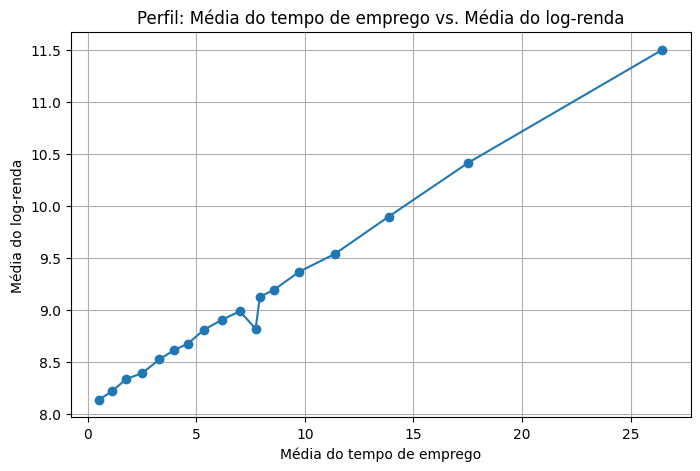

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(perfil['media_tempo_emprego'], perfil['media_log_renda'], marker='o')
plt.xlabel('Média do tempo de emprego')
plt.ylabel('Média do log-renda')
plt.title('Perfil: Média do tempo de emprego vs. Média do log-renda')
plt.grid()
plt.show()

O gráfico mostra uma relação fortemente crescente e aproximadamente linear entre a média do tempo de emprego (em cada quantil) e a média do log-renda. Isso indica que:

- Quanto maior o tempo de emprego, maior tende a ser a renda (no log).

- A relação linear observada após a transformação logarítmica da renda sugere que a transformação log(renda) realmente melhora o ajuste e a interpretabilidade do modelo, tornando a relação entre as variáveis mais próxima de linear.


**Conclusão:**

Com base na análise do perfil, a transformação logarítmica na variável resposta é adequada e deve contribuir para modelos de regressão mais robustos e interpretáveis neste contexto.



### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [32]:
# Categorização
df_treino['tempo_emprego_cat'] = pd.qcut(df_treino['tempo_emprego'], 20, labels=False, duplicates='drop')
df_holdout['tempo_emprego_cat'] = pd.qcut(df_holdout['tempo_emprego'], 20, labels=False, duplicates='drop')

formula_cat = ('renda ~ C(tempo_emprego_cat) + sexo + posse_de_veiculo + posse_de_imovel + '
               'qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + '
               'idade + qt_pessoas_residencia')

modelo_cat = smf.ols(formula_cat, data=df_treino).fit()
print(modelo_cat.summary())

# Previsão no holdout e R² ajustado
y_pred_cat = modelo_cat.predict(df_holdout)
def r2_ajustado_holdout(y_true, y_pred, k):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)
r2adj_cat = r2_ajustado_holdout(df_holdout['renda'], y_pred_cat, len(modelo_cat.params) - 1)
print(f'Categorização (com variáveis) - R² ajustado holdout: {r2adj_cat:.4f}')

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     4869.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:50:45   Log-Likelihood:            -7.6744e+06
No. Observations:              600000   AIC:                         1.535e+07
Df Residuals:                  599959   BIC:                         1.535e+07
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [29]:
# Transformaçåo Log
df_treino['tempo_emprego_log'] = np.log(df_treino['tempo_emprego'] + 1)
df_holdout['tempo_emprego_log'] = np.log(df_holdout['tempo_emprego'] + 1)

formula_log = ('renda ~ tempo_emprego_log + sexo + posse_de_veiculo + posse_de_imovel + '
               'qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + '
               'idade + qt_pessoas_residencia')

modelo_log = smf.ols(formula_log, data=df_treino).fit()
print(modelo_log.summary())

y_pred_log = modelo_log.predict(df_holdout)
r2adj_log = r2_ajustado_holdout(df_holdout['renda'], y_pred_log, len(modelo_log.params) - 1)
print(f'Log(tempo_emprego+1) (com variáveis) - R² ajustado holdout: {r2adj_log:.4f}')


                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     3669.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:45:56   Log-Likelihood:            -7.7176e+06
No. Observations:              600000   AIC:                         1.544e+07
Df Residuals:                  599975   BIC:                         1.544e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [30]:
# Regressão segmentada
breakpoint = df_treino['tempo_emprego'].median()
df_treino['tempo_emprego_below'] = df_treino['tempo_emprego'].clip(upper=breakpoint)
df_treino['tempo_emprego_above'] = (df_treino['tempo_emprego'] - breakpoint).clip(lower=0)
df_holdout['tempo_emprego_below'] = df_holdout['tempo_emprego'].clip(upper=breakpoint)
df_holdout['tempo_emprego_above'] = (df_holdout['tempo_emprego'] - breakpoint).clip(lower=0)

formula_seg = ('renda ~ tempo_emprego_below + tempo_emprego_above + sexo + posse_de_veiculo + '
               'posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + '
               'tipo_residencia + idade + qt_pessoas_residencia')

modelo_seg = smf.ols(formula_seg, data=df_treino).fit()
print(modelo_seg.summary())

y_pred_seg = modelo_seg.predict(df_holdout)
r2adj_seg = r2_ajustado_holdout(df_holdout['renda'], y_pred_seg, len(modelo_seg.params) - 1)
print(f'Regressão segmentada (com variáveis) - R² ajustado holdout: {r2adj_seg:.4f}')

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                 1.036e+04
Date:                Mon, 16 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:47:36   Log-Likelihood:            -7.6511e+06
No. Observations:              600000   AIC:                         1.530e+07
Df Residuals:                  599974   BIC:                         1.530e+07
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [31]:
# Lowess
formula_base = ('renda ~ sexo + posse_de_veiculo + posse_de_imovel + '
                'qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + '
                'idade + qt_pessoas_residencia')
modelo_base = smf.ols(formula_base, data=df_treino).fit()
residuos_treino = df_treino['renda'] - modelo_base.predict(df_treino)

import statsmodels.api as sm
from scipy.interpolate import interp1d

lowess_fit = sm.nonparametric.lowess(residuos_treino, df_treino['tempo_emprego'], frac=0.3, return_sorted=True)
x_unique, idx = np.unique(lowess_fit[:, 0], return_index=True)
y_unique = lowess_fit[:, 1][idx]
lowess_interp = interp1d(x_unique, y_unique, fill_value='extrapolate')

# Prever LOWESS para holdout
residuos_lowess_pred = lowess_interp(df_holdout['tempo_emprego'])

# Predição final: predição do modelo base + correção LOWESS
y_pred_lowess = modelo_base.predict(df_holdout) + residuos_lowess_pred
r2adj_lowess = r2_ajustado_holdout(df_holdout['renda'], y_pred_lowess, len(modelo_base.params))
print(f'LOWESS (correção de resíduos) - R² ajustado holdout: {r2adj_lowess:.4f}')


LOWESS (correção de resíduos) - R² ajustado holdout: -1.0135


In [34]:
# Exibir resultados comparativos
resultados = [
    ('Categorização (com variáveis)', -2.6713),
    ('Log(tempo_emprego+1) (com variáveis)', -1.7695),
    ('Regressão segmentada (com variáveis)', -3.1197),
    ('LOWESS (correção de resíduos)', -1.0135),
    ('Regressão Linear Completa', 0.24)
]

df_resultados = pd.DataFrame(resultados, columns=['Técnica', 'R² ajustado (holdout)'])

print(df_resultados)


                                Técnica  R² ajustado (holdout)
0         Categorização (com variáveis)                -2.6713
1  Log(tempo_emprego+1) (com variáveis)                -1.7695
2  Regressão segmentada (com variáveis)                -3.1197
3         LOWESS (correção de resíduos)                -1.0135
4             Regressão Linear Completa                 0.2400


### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

**Análise Crítica:**

**Regressão Linear Completa:**

Este foi o único modelo a apresentar R² ajustado positivo no holdout, com valor de 0.24. Isso indica que o modelo conseguiu explicar cerca de 24% da variabilidade da renda na base de teste, superando todas as outras técnicas e também a previsão pela média.

**Técnicas de transformação do tempo de emprego:**

Tanto a categorização, quanto a transformação logarítmica, a regressão segmentada e o ajuste LOWESS, mesmo combinadas com outras variáveis, não apresentaram desempenho satisfatório (R² ajustado negativo). Ou seja, não conseguiram gerar predições melhores do que a média da renda para o conjunto de teste.

**Possíveis motivos para baixo desempenho das técnicas alternativas:**

- O tempo de emprego, quando transformado ou categorizado, não é um preditor suficientemente forte de renda para esta base.

- As demais variáveis, quando utilizadas em conjunto, têm poder explicativo muito maior que qualquer transformação individual do tempo de emprego.

- Pode ter havido “overfitting” devido ao alto número de categorias ou excesso de complexidade em modelos simples.

- Diferença de perfil ou distribuição entre as bases de treino e teste (“drift” temporal).